In [ ]:
import kagglehub
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Input,
    Dropout
)

from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.applications import MobileNetV3Large
from keras.layers import GlobalAveragePooling2D
from keras.models import Model

In [ ]:
def plot_history(history):
  """
  Funkce na vykreslení dat z objectu history -> vrací ho metoda fit keras modelu
  """
  # plot the Loss curve(s)
  plt.figure(figsize=[8,6])

  plt.plot(history.history['loss'],'r',linewidth=3.0)
  plt.plot(history.history['val_loss'],'b',linewidth=3.0)

  plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)
  plt.show()

  # plot the Accuracy curve(s)
  plt.figure(figsize=[8,6])

  plt.plot(history.history['accuracy'], 'r', linewidth=3.0)
  plt.plot(history.history['val_accuracy'], 'b',linewidth=3.0)

  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Accuracy',fontsize=16)
  plt.title('Accuracy Curves',fontsize=16)
  plt.show()

In [ ]:
# The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

# The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories 

#(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). 

#The training set consists of 28,709 examples and the public test set consists of 3,589 examples.

## Načtení a preprocessing dat

In [ ]:
# Stáhnout aktuální verzi datasetu
# Pozor -> musíte vytvořit složku .kaggle a do ní vložit svůj kaggle.json soubor s přístupy
# návod https://www.kaggle.com/docs/api#authentication

path = kagglehub.dataset_download("msambare/fer2013")
print("Path to dataset files:", path)

In [ ]:
# data se stáhly sem -> ručně jsem hledal, od jaké úrovně složek už jsou data
fotky_emoce = os.listdir(f"{path}/train")
fotky_emoce

In [ ]:
# potřebuji načíst fotky, k fotkám labely a uložit si, jaký label patří k jaké figurce
X = []
y = []
encoding = {}
# pro každou složku s figurkami
for index, emoce in enumerate(fotky_emoce):
  # uložíme si přiřazení číel k labelům y
  encoding[index] = emoce
  # složka s fotkami kontrétních emoci
  folder_path = os.path.join(f"{path}/train", emoce)

  # sem načteme fotky konkrétních emoci
  image_list = []
  # pro každý soubor ze složky
  for filename in os.listdir(folder_path):
    # pokud se jedná o .jpg
    if filename.endswith(".jpg"):
        # cesta ke kokrétnímu souboru
        img_path = os.path.join(folder_path, filename)
        # načti obrázek ze souboru
        img = Image.open(img_path)
        # Změň rozlišení na 224x224 -> všechny budou mít stejný rozměr
        img_resized = img.resize((48, 48))
        # převeď na numpy array
        img_array = np.array(img_resized)
        # přidat do listu k ostatním
        image_list.append(img_array)
  # do X přidej obrázky z další složky (respektive emoce)
  X += image_list
  # vytvoříme list s labely (rovnou jako čísla, ať nemusíme pozdějí dělat encoding)
  # přiřazení čísel k labelům máme v proměnné 'encoding'
  y += [index] * len(image_list)

In [ ]:
# převést list s numpy arrayi pro každou emoci na numpy array (tenzor)
X = np.stack(X)
# převést list y na numpy array
y = np.array(y)

In [ ]:
# transfer learning viz. níže -> zvolili jsme Mobilnetv3 jako základ
# ten vyžaduje hodnoty pixelů v rozmezí od 0-255 -> neškálovat!
X_not_scaled = X.copy()

In [ ]:
# škálujeme pro náš vlastní model
X = X / 255

In [ ]:
# rozdělení, trénink test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)
# one hot encoding y -> musí sedět rozměr s výstupem softmax vrstvy
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
early = EarlyStopping(
    # sleduj přesnost u validačních dat
    monitor="val_accuracy",
    # pokud se nezlepší alespoň o 0.3%
    min_delta=0.003,
    # za posledních 10 epoch
    patience=10,
    # tak to vypni, a načti váhy z epochy, kdy byla nejvyšší přesnost na validačních datech
    restore_best_weights=True,
    start_from_epoch = 50
)

save = ModelCheckpoint(
    # kam uložit model
    filepath="best_model.keras",
    # sleduj přesnost u validačních dat
    monitor="val_accuracy",
    # ulož vždy jen jeden soubor s nejlepší hodnotou metriky
    save_best_only=True,
    # ulož do jednoho souboru architekturu i váhy
    save_weights_only=False,
    # po každé epoše
    save_freq="epoch"
)

## Vlastní neuronka

In [11]:
# vytvoříme vlastní model - inspirace VGG16 architektura
model = Sequential()
# vstup musí sedět na X
model.add(Input(shape=(48, 48, 1)))
## model.add(Input(shape=X_train.shape[1:]))
# blok konvoluce s poolingem
model.add(Conv2D(16, (3, 3),input_shape=(48, 48, 1)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (4, 4)))
model.add(MaxPooling2D())
# převést na vektor
model.add(Flatten())
# regularizace proti overfittingu
model.add(Dropout(0.2))
# výstupní vrstva -> multiclass single label -> softmax
model.add(Dense(len(fotky_emoce), activation="softmax"))

# kompilace
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

C:\Users\zitao\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 20, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │        22,407 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,791 (120.28 KB)

 Trainable params: 30,791 (120.28 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test), batch_size=32, callbacks=[early, save])

Epoch 1/25
718/718 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.3157 - loss: 1.7186 - val_accuracy: 0.4154 - val_loss: 1.5287
Epoch 2/25
718/718 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.4328 - loss: 1.4900 - val_accuracy: 0.4507 - val_loss: 1.4525
Epoch 3/25
718/718 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.4647 - loss: 1.4116 - val_accuracy: 0.4620 - val_loss: 1.4182
Epoch 4/25
718/718 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.4870 - loss: 1.3674 - val_accuracy: 0.4542 - val_loss: 1.4401
Epoch 5/25
718/718 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.5055 - loss: 1.3361 - val_accuracy: 0.4751 - val_loss: 1.4028
Epoch 6/25
718/718 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.5173 - loss: 1.2999 - val_accuracy: 0.4692 - val_loss: 1.4171
Epoch 7/25
718/718 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.5303 - loss: 1.2701 - val_accuracy: 0.4808 - val_loss: 1.3866
Epoch 8/25
718/718 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.5308 - loss: 1.2554 - 

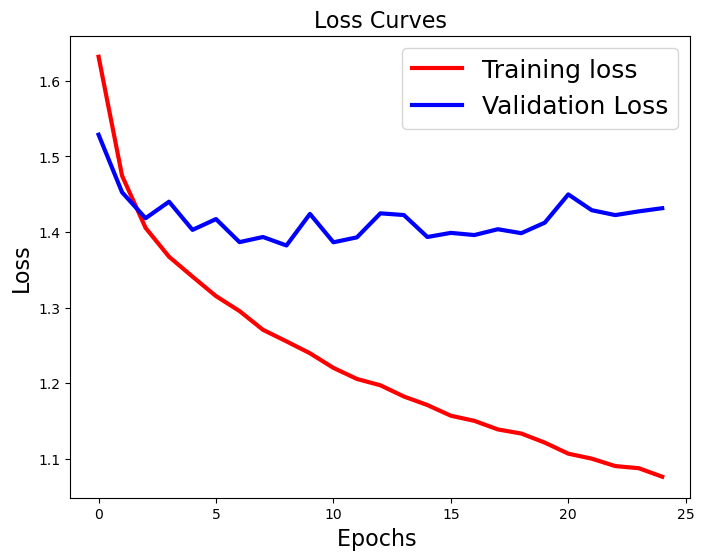

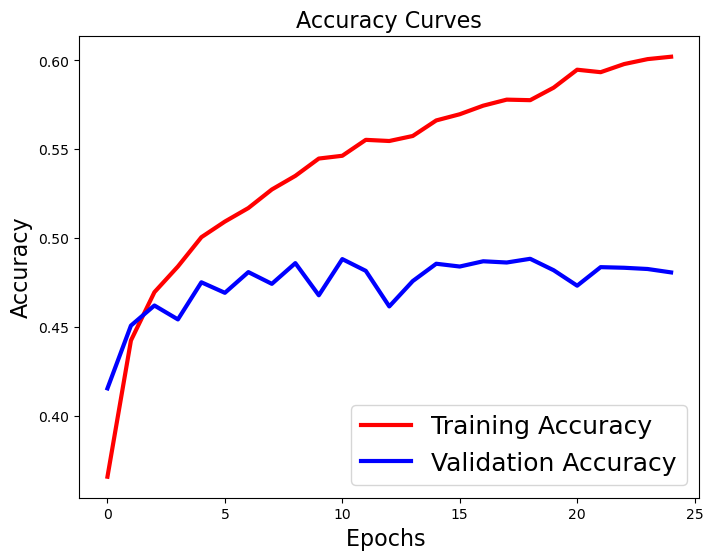

In [13]:
plot_history(history)

## Transfer learning

In [16]:
# vytvořit trénovací sadu z nenaškálovaných dat
X_train, X_test, y_train, y_test = train_test_split(
    X_not_scaled, y, test_size=0.2, stratify=y, random_state=42)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [17]:
# načtení konvoluční featur extraction části MobilnetV3
base_model = MobileNetV3Large(
    input_shape=(48, 48, 1),
    include_top=False,
    weights="imagenet",
)

C:\Users\zitao\anaconda3\Lib\site-packages\keras\src\applications\mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


ValueError: Shape mismatch in layer #0 (named conv)for weight conv/kernel. Weight expects shape (3, 3, 1, 16). Received saved weight with shape (3, 3, 3, 16)

In [ ]:
# první MobilnetV3 konvoluční část
x = base_model.output
# převod na vektor s redukcí dat pomocí poolingu
x = GlobalAveragePooling2D()(x)
# stejná klasifikační vrstva jako u vlastní neuronky
# regularizace
x = Dropout(0.2)(x)
# softmax vrstva podle úlohy
predictions = Dense(len(fotky_emoce), activation="softmax")(x)

# spojíme do kupy
model = Model(inputs=base_model.input, outputs=predictions)

# nepřetrénovávat MobilnetV3 vrstvy -> učíme pouze klasifikátor
for layer in base_model.layers:
    layer.trainable = False

# kompilace stejná jako u vlastní neuronky
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

In [ ]:
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test), batch_size=32, callbacks=[early, save])

In [ ]:
plot_history(history)